# Homework 2. Языковые модели.

#### Задача определения частей речи, Part-Of-Speech Tagger (POS)

Мы будем решать задачу определения частей речи (POS-теггинга) с помощью скрытой марковской модели (HMM).

In [2]:
import nltk
import pandas as pd
import numpy as np
from collections import OrderedDict, deque
from nltk.corpus import brown
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
nltk.download("brown")

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Sergei\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

Используем универсальную систему тегирования universal_tagset.

In [4]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\Sergei\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

Мы имеем массив предложений пар (слово-тег)

In [5]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")
brown_tagged_sents

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

In [6]:
type(brown_tagged_sents)

nltk.corpus.reader.util.ConcatenatedCorpusView

In [7]:
brown_tagged_sents[0]

[('The', 'DET'),
 ('Fulton', 'NOUN'),
 ('County', 'NOUN'),
 ('Grand', 'ADJ'),
 ('Jury', 'NOUN'),
 ('said', 'VERB'),
 ('Friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP'),
 ("Atlanta's", 'NOUN'),
 ('recent', 'ADJ'),
 ('primary', 'NOUN'),
 ('election', 'NOUN'),
 ('produced', 'VERB'),
 ('``', '.'),
 ('no', 'DET'),
 ('evidence', 'NOUN'),
 ("''", '.'),
 ('that', 'ADP'),
 ('any', 'DET'),
 ('irregularities', 'NOUN'),
 ('took', 'VERB'),
 ('place', 'NOUN'),
 ('.', '.')]

In [8]:
brown_tagged_words = brown.tagged_words(tagset='universal')
brown_tagged_words[0:10]

[('The', 'DET'),
 ('Fulton', 'NOUN'),
 ('County', 'NOUN'),
 ('Grand', 'ADJ'),
 ('Jury', 'NOUN'),
 ('said', 'VERB'),
 ('Friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP')]

Проанализируем данные

In [9]:
brown_tagged_words = list(map(lambda x: (x[0].lower(), x[1]), brown_tagged_words))

In [10]:
brown_tagged_words[0:10]

[('the', 'DET'),
 ('fulton', 'NOUN'),
 ('county', 'NOUN'),
 ('grand', 'ADJ'),
 ('jury', 'NOUN'),
 ('said', 'VERB'),
 ('friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP')]

In [11]:
len(brown_tagged_words)

1161192

In [12]:
#help(nltk.FreqDist)

In [13]:
print('Кол-во предложений: ', len(brown_tagged_sents))
tags = [tag for (word, tag) in brown_tagged_words]
words = [word for (word, tag) in brown_tagged_words]

tag_num = pd.Series(nltk.FreqDist(tags)).sort_values(ascending=False)
word_num = pd.Series(nltk.FreqDist(words)).sort_values(ascending=False)

Кол-во предложений:  57340


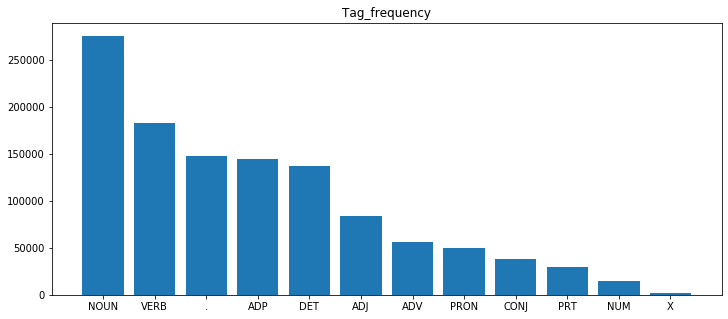

In [14]:
plt.figure(figsize=(12, 5))
plt.bar(tag_num.index, tag_num.values)
plt.title("Tag_frequency")
plt.show()

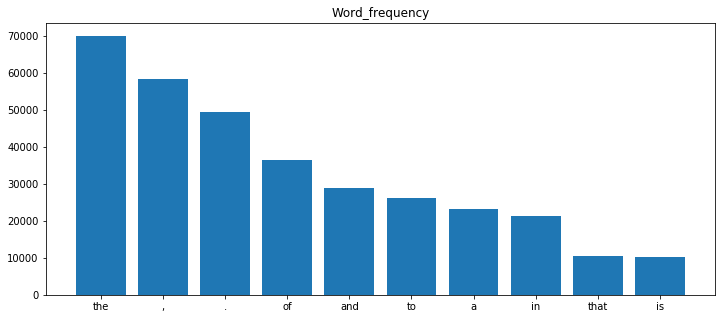

In [15]:
plt.figure(figsize=(12, 5))
plt.bar(word_num.index[:10], word_num.values[:10])
plt.title("Word_frequency")
plt.show()

### Вопрос 1:

Кол-во слова cat в корпусе?

In [16]:
word_num['cat']

23

### Вопрос 2

Самое популярное слово с самым популярным тегом?

In [17]:
most_popular_tag = tag_num.index[0]

#NOUN
words_with_popular_tag = [word for (word,tag) in brown_tagged_words if tag == most_popular_tag]

pop_word = pd.Series(nltk.FreqDist(words_with_popular_tag)).sort_values(ascending=False).index[0]

print(pop_word)

time


Категории корпуса:

In [18]:
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

Будем работать с категорией humor

Cделайте случайное разбиение выборки на обучение и контроль в отношении 9:1.

In [1]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")
my_brown_tagged_sents = []

for sent in brown_tagged_sents:
    my_brown_tagged_sents.append(list(map(lambda x: (x[0].lower(),x[1]), sent)))

my_brown_tagged_sents = np.array(my_brown_tagged_sents)

NameError: name 'brown' is not defined

In [20]:
train_sents, test_sents = train_test_split(my_brown_tagged_sents, test_size=0.1, shuffle=True)

In [21]:
len(train_sents)

947

In [22]:
len(test_sents)

106

## 1. Марковские цепи

### [Обучение] Метод максимального правдоподобия для обучения модели

* $\normalsize S = s_0, s_1, ..., s_N$ - скрытые состояния, то есть различные теги
* $\normalsize O = o_0, o_1, ..., o_M$ - различные слова
* $\normalsize a_{i,j} = p(s_j|s_i)$ - вероятность того, что, находясь в скрытом состоянии $s_i$, мы попадем в состояние $s_j$ (элемент матрицы $A$)
* $\normalsize b_{k,j}=p(o_k|s_j)$ - вероятность того, что при скрытом состоянии $s_j$ находится слово $o_k$(элемент матрицы $B$)

$$\normalsize x_t \in O, y_t \in S$$
$\normalsize (x_t, y_t)$ - слово и тег, стоящие на месте $t$ $\Rightarrow$ 
* $\normalsize X$ - последовательность слов
* $\normalsize Y$ - последовательность тегов

Требуется построить скрытую марковскую модель (class HiddenMarkovModel) и написать метод fit для настройки всех её параметров с помощью оценок максимального правдоподобия по размеченным данным (последовательности пар слово+тег):

- Вероятности переходов между скрытыми состояниями $p(y_t | y_{t - 1})$ посчитайте на основе частот биграмм POS-тегов.


- Вероятности эмиссий наблюдаемых состояний $p(x_t | y_t)$ посчитайте на основе частот "POS-тег - слово".


- Распределение вероятностей начальных состояний $p(y_0)$ задайте равномерным.

Пример $X = [x_0, x_1], Y = [y_0, y_1]$:<br><br>
$$p(X, Y) = p(x_0, x_1, y_0, y_1) = p(y_0) \cdot p(x_0, x_1, y_1 | y_0) = p(y_0) \cdot p(x_0 | y_0) \cdot
p(x_1, y_1 | x_0, y_0) = \\ = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | x_0, y_0) \cdot p(x_1 | x_0, y_0, y_1)
= (\text{в силу условий наши модели}) = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | y_0) \cdot p(x_1 | y_1) \Rightarrow$$ <br>
Для последовательности длины $n + 1$:<br>
$$p(X, Y) = p(x_0 ... x_{n - 1}, y_0 ... y_{n - 1}) \cdot p(y_n | y_{n - 1}) \cdot p(x_n | y_n)$$

### [Предсказание] Алгоритм Витерби для применения модели


Требуется написать метод .predict для определения частей речи на тестовой выборке. Чтобы использовать обученную модель на новых данных, необходимо реализовать алгоритм Витерби. Это алгоритм динамического программирования, с помощью которого мы будем находить наиболее вероятную последовательность скрытых состояний модели для фиксированной последовательности слов:

$$ \hat{Y} = \arg \max_{Y} p(Y|X) = \arg \max_{Y} p(Y, X) $$

Пусть $\normalsize Q_{t,s}$ - самая вероятная последовательность скрытых состояний длины $t$ с окончанием в состоянии $s$. $\normalsize q_{t, s}$ - вероятность этой последовательности.
$$(1)\: \normalsize q_{t,s} = \max_{s'} q_{t - 1, s'} \cdot p(s | s') \cdot p(o_t | s)$$
$\normalsize Q_{t,s}$ можно восстановить по argmax-ам.

In [23]:
class HiddenMarkovModel:    
    def __init__(self):
    
        pass
        
    def fit(self, train_tokens_tags_list):
        """
        train_tokens_tags_list: массив предложений пар слово-тег (выборка для train) 
        """
        tags = [tag for sent in train_tokens_tags_list
                    for (word, tag) in sent]
        words = [word for sent in train_tokens_tags_list
                      for (word, tag) in sent]
        
        tag_num = pd.Series(nltk.FreqDist(tags)).sort_index()
        word_num = pd.Series(nltk.FreqDist(words)).sort_values(ascending=False)
         
        self.tags = tag_num.index
        self.words = word_num.index
        
        A = pd.DataFrame({'{}'.format(tag) : [0] * len(tag_num) for tag in tag_num.index}, index=tag_num.index)
        B = pd.DataFrame({'{}'.format(tag) : [0] * len(word_num) for tag in tag_num.index}, index=word_num.index)
        
        # Вычисляем матрицу A и B по частотам слов и тегов
        
        # sent - предложение
        # sent[i][0] - i слово в этом предложении, sent[i][1] - i тег в этом предложении
        for sent in train_tokens_tags_list:
            for i in range(len(sent)):
                B.loc[sent[i][0], sent[i][1]] += 1 # текущая i-пара слово-тег (обновите матрицу B аналогично A)
                if len(sent) - 1 != i: # для последнего тега нет следующего тега
                    A.loc[sent[i][1], sent[i + 1][1]] += 1 # пара тег-тег
                
        
        # переходим к вероятностям
        
        # нормируем по строке, то есть по всем всевозможным следующим тегам
        A = A.divide(A.sum(axis=1), axis=0)
        
        # нормируем по столбцу, то есть по всем всевозможным текущим словам
        B = B / np.sum(B, axis=0)
        
        self.A = A
        self.B = B
        
        return self
        
    
    def predict(self, test_tokens_list):
        """
        test_tokens_list : массив предложений пар слово-тег (выборка для test)
        """
        predict_tags = OrderedDict({i : np.array([]) for i in range(len(test_tokens_list))})
        
        for i_sent in range(len(test_tokens_list)):
            
            current_sent = test_tokens_list[i_sent] # текущее предложение
            len_sent = len(current_sent) # длина предложения 
            
            q = np.zeros(shape=(len_sent + 1, len(self.tags)))
            q[0] = 1 # нулевое состояние (равномерная инициализация по всем s)
            back_point = np.zeros(shape=(len_sent + 1, len(self.tags))) # # argmax
            
            for t in range(len_sent):
                
                # если мы не встречали такое слово в обучении, то вместо него будет 
                # самое популярное слово с самым популярным тегом (вопрос 2)
                if current_sent[t] not in self.words:
                    current_sent[t] = pop_word
                    
                # через max выбираем следующий тег
                for i_s in range(len(self.tags)):
                    
                    s = self.tags[i_s]
                    
                    # формула (1)
                    q[t + 1][i_s] = np.max(q[t,:] *
                        self.A.loc[:, s] * 
                        self.B.loc[current_sent[t], s])
                    
                    # argmax формула(1)
                    
                    # argmax, чтобы восстановить последовательность тегов
                    back_point[t + 1][i_s] = (q[t,:] *
                        self.A.loc[:, s] * 
                        self.B.loc[current_sent[t], s]).reset_index()[s].idxmax() # индекс 
                    
            back_point = back_point.astype('int')
            
            # выписываем теги, меняя порядок на реальный
            back_tag = deque()
            current_tag = np.argmax(q[len_sent])
            for t in range(len_sent, 0, -1):
                back_tag.appendleft(self.tags[current_tag])
                current_tag = back_point[t, current_tag]
             
            predict_tags[i_sent] = np.array(back_tag)
        
        
        return predict_tags   

Обучаем

In [24]:
markov_model = HiddenMarkovModel()
markov_model.fit(train_sents)

In [25]:
markov_model.A

,.,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRON,PRT,VERB,X
.,0.238316,0.035632,0.094863,0.060157,0.096714,0.104118,0.100416,0.006941,0.106432,0.038871,0.114299,0.003239
ADJ,0.154096,0.057583,0.090835,0.012976,0.034063,0.007299,0.585564,0.002433,0.010543,0.027575,0.013788,0.003244
ADP,0.019752,0.055581,0.022508,0.017915,0.000919,0.462563,0.235645,0.017915,0.110243,0.020211,0.035829,0.000919
ADV,0.188269,0.157048,0.101230,0.086093,0.014191,0.063387,0.032167,0.006623,0.073794,0.027436,0.248817,0.000946
CONJ,0.055385,0.096923,0.066154,0.095385,0.001538,0.149231,0.167692,0.016923,0.106154,0.021538,0.218462,0.004615
DET,0.018993,0.220406,0.006184,0.020760,0.000442,0.005300,0.646201,0.006625,0.017226,0.002208,0.053004,0.002650
NOUN,0.329605,0.011186,0.218742,0.035297,0.062391,0.017151,0.128511,0.001740,0.026597,0.018891,0.149142,0.000746
NUM,0.095890,0.116438,0.136986,0.000000,0.041096,0.006849,0.534247,0.027397,0.000000,0.006849,0.034247,0.000000
PRON,0.103948,0.004029,0.061241,0.063658,0.007252,0.024174,0.003223,0.005641,0.007252,0.019339,0.699436,0.000806
PRT,0.128501,0.014827,0.088962,0.059308,0.011532,0.088962,0.018122,0.003295,0.006590,0.013180,0.566722,0.000000


In [26]:
markov_model.B

,.,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRON,PRT,VERB,X
",",0.389694,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
the,0.000000,0.0,0.0,0.0,0.000000,0.414311,0.000000,0.0,0.0,0.0,0.000000,0.0
.,0.254428,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
a,0.000000,0.0,0.0,0.0,0.000000,0.212898,0.000000,0.0,0.0,0.0,0.000000,0.0
and,0.000000,0.0,0.0,0.0,0.738462,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
gaming,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000308,0.0
dissipated,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000308,0.0
monies,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000248,0.0,0.0,0.0,0.000000,0.0
clothes,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000248,0.0,0.0,0.0,0.000000,0.0


Проверьте работу реализованного алгоритма на следующих модельных примерах, проинтерпретируйте результат.

'He can stay'
'a cat and a dog'
'I have a television'
'My favourite character'

In [27]:
sents = [['He', 'can', 'stay'], ['a', 'cat', 'and', 'a', 'dog'], ['I', 'have', 'a', 'television'],
         ['My', 'favourite', 'character']]

In [28]:
markov_model.predict(sents)

OrderedDict([(0, array(['NOUN', 'VERB', 'VERB'], dtype='<U4')),
             (1, array(['DET', 'NOUN', 'CONJ', 'DET', 'NOUN'], dtype='<U4')),
             (2, array(['NOUN', 'VERB', 'DET', 'NOUN'], dtype='<U4')),
             (3, array(['NOUN', 'NOUN', 'NOUN'], dtype='<U4'))])

В целом алгоритм работает. В последнем предложении не правильно определились прилагательные (слова favourite нет в словаре, поэтому подставилось самое популярное слово с самым популярным тегом (time)).

### Вопрос 3:

Какой тег вы получили для слова can?

In [29]:
markov_model.predict([['can']])[0][0]

'VERB'

### Вопрос 4:

Какой тег вы получили для слова favourite?

In [30]:
markov_model.predict([['favourite']])[0][0]

'NOUN'

In [31]:
markov_model.predict([['favorite']])[0][0]

'ADJ'

Примените модель к отложенной выборке Брауновского корпуса и подсчитайте точность определения тегов (accuracy). Сделайте выводы. 

In [32]:
def accuracy_score(model, sents):
    true_pred = 0
    num_pred = 0

    for sent in sents:        
        tags = [tag for (word,tag) in sent]
        words = [word for (word,tag) in sent]

        outputs = markov_model.predict([words])[0]        
        true_pred += np.sum(tags == outputs)
        
        num_pred += len(words)
    acc = true_pred / num_pred * 100
    print("Accuracy:", true_pred / num_pred * 100, '%')
    
    return acc

In [33]:
acc = accuracy_score(markov_model, test_sents)

Accuracy: 89.4291754756871 %


Вывод: нужно обучиться на большем корпусе, чтобы увеличить словарь.

### Вопрос 5:

Какое качество вы получили(округлите до одного знака после запятой)?

In [34]:
print(acc)

89.4291754756871


## 2. DefaultTagger

### Вопрос 6:

Какое качество вы бы получили, если бы предсказывали любой тег, как самый популярный тег на выборке train(округлите до одного знака после запятой)?

In [35]:
true_pred = 0
num_pred = 0

for sent in test_sents:
    tags = np.array([tag for (word, tag) in sent])
    words = np.array([word for (word, tag) in sent])

    true_pred += np.sum(['NOUN'] * len(words) == tags)
    num_pred += len(words)
print("Accuracy:", true_pred / num_pred * 100, '%')

Accuracy: 20.031712473572938 %


Вы можете испоьзовать DefaultTagger(метод tag для предсказания частей речи предложения) или можете преобразовать код выше

In [36]:
from nltk.tag import DefaultTagger
default_tagger = DefaultTagger('NOUN')

In [37]:
true_pred = 0
num_pred = 0

for sent in test_sents:
    tags = np.array([tag for (word, tag) in sent])
    words = np.array([word for (word, tag) in sent])
    
    tagged_sent = default_tagger.tag(words)
    outputs = [tag for token, tag in tagged_sent]
    
    true_pred += np.sum(outputs == tags)
    num_pred += len(words)
    
print("Accuracy:", true_pred / num_pred * 100, '%')

Accuracy: 20.031712473572938 %


## 3. Модель Стенфорда

Скачайте предобученную модель от Стэнфорда: https://nlp.stanford.edu/software/tagger.shtml и примените к тестовым данным. Не забудьте преобразовать систему тэгов из 'en-ptb' в 'universal' с помощью функции map_tag.

In [38]:
from nltk.tag.stanford import StanfordPOSTagger
from nltk.tag.mapping import map_tag

# используйте путь до jar и до model
jar = u'D:\ml\stanford-postagger-2018-10-16\stanford-postagger-3.9.2.jar'
model = u'D:\ml\stanford-postagger-2018-10-16\models\english-bidirectional-distsim.tagger'
stanford_tagger = StanfordPOSTagger(model, jar, encoding='utf8')

# проверим на предложении
tagged_sent = stanford_tagger.tag(['I', 'bear', 'a', 'bag'])
print('Ответ: ', [map_tag('en-ptb', 'universal', tag) for token, tag in tagged_sent])

Ответ:  ['PRON', 'VERB', 'DET', 'NOUN']


### Вопрос 7:

Какое качество вы получили на модели Стенфорда?

In [39]:
true_pred = 0
num_pred = 0

for sent in test_sents:
    tags = np.array([tag for (word, tag) in sent])
    words = np.array([word for (word, tag) in sent])
    
    tagged_sent = stanford_tagger.tag(words)
    outputs = [map_tag('en-ptb', 'universal', tag) for token, tag in tagged_sent]
    
    true_pred += np.sum(outputs == tags)
    num_pred += len(words)
    
print("Accuracy:", true_pred / num_pred * 100, '%')

Accuracy: 90.9090909090909 %


## 4. BiLSTMTagger

Подготовим данные. Возьмем полный датасет.

In [221]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")

In [223]:
pos_data = [list(zip(*sent)) for sent in brown_tagged_sents]
print(pos_data[0])

[('The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'), ('DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.')]


Напишем модель на torch'e

In [224]:
from torchtext.data import Field, BucketIterator
import torchtext

# наши поля
WORD = Field(lower=True)
TAG = Field(unk_token=None) # все токены нам извсетны

# создаем примеры
examples = []
for words, tags in pos_data:
    examples.append(torchtext.data.Example.fromlist([list(words), list(tags)], fields=[('words', WORD), ('tags', TAG)]))

In [225]:
# кладем примеры в наш датасет
dataset = torchtext.data.Dataset(examples, fields=[('words', WORD), ('tags', TAG)])

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.1, 0.1])

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 45872
Number of validation examples: 5734
Number of testing examples: 5734


In [46]:
help(Field)

Help on class Field in module torchtext.data.field:

class Field(RawField)
 |  Field(sequential=True, use_vocab=True, init_token=None, eos_token=None, fix_length=None, dtype=torch.int64, preprocessing=None, postprocessing=None, lower=False, tokenize=None, tokenizer_language='en', include_lengths=False, batch_first=False, pad_token='<pad>', unk_token='<unk>', pad_first=False, truncate_first=False, stop_words=None, is_target=False)
 |  
 |  Defines a datatype together with instructions for converting to Tensor.
 |  
 |  Field class models common text processing datatypes that can be represented
 |  by tensors.  It holds a Vocab object that defines the set of possible values
 |  for elements of the field and their corresponding numerical representations.
 |  The Field object also holds other parameters relating to how a datatype
 |  should be numericalized, such as a tokenization method and the kind of
 |  Tensor that should be produced.
 |  
 |  If a Field is shared between two columns i

Построим словарь

In [226]:
#[item for ex in train_data.examples for item in ex.words]

WORD.build_vocab([ex.words for ex in train_data.examples], min_freq=2)
TAG.build_vocab([ex.tags for ex in train_data.examples])

print(f"Unique tokens in source (ru) vocabulary: {len(WORD.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TAG.vocab)}")

print(WORD.vocab.itos[::200])
print(TAG.vocab.itos)

Unique tokens in source (ru) vocabulary: 24764
Unique tokens in target (en) vocabulary: 13
['<unk>', '2', 'known', 'actually', 'series', 'reasons', 'financial', 'removed', 'newspaper', 'soft', 'imagine', 'theme', 'fill', 'contribute', 'pleased', 'thanks', "world's", 'adjustment', 'prayer', 'criminal', 'rank', 'variables', 'bold', 'angels', 'theirs', 'relating', 'molding', 'explosive', 'whip', 'lemon', 'byron', 'pearson', 'breaks', 'minnesota', 'whisper', 'framed', 'screens', 'bumblebees', 'hunt', 'reviews', 'atlas', 'forecast', 'pathological', 'tyranny', 'carmer', 'folly', 'negotiate', 'similarity', 'aborigine', 'clad', 'fe', 'lays', 'polar', 'spiritually', "'round", 'bong', 'decorator', 'formations', 'jelke', 'overcoming', 'rip', 'tedious', '10-year-old', 'banana', 'clinging', 'disrupted', 'florence', 'idly', 'lullaby', 'outputs', 'reconsider', 'skiffs', 'torque', 'wrapping', 'afghan', 'beatie', 'censure', 'corrugated', 'disinterest', 'falsity', 'grandiose', 'incandescent', 'lanes', '

In [227]:
print(vars(train_data.examples[9]))

{'words': ['he', 'was', 'bitter', 'and', 'resentful', 'toward', 'her', ',', 'personally', 'resentful', '.'], 'tags': ['PRON', 'VERB', 'ADJ', 'CONJ', 'ADJ', 'ADP', 'PRON', '.', 'ADV', 'ADJ', '.']}


Посмотрим с насколько большими предложениями мы имеем дело

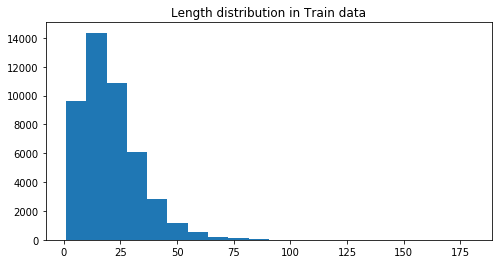

In [228]:
length = map(len, [vars(x)['words'] for x in train_data.examples])

plt.figure(figsize=[8, 4])
plt.title("Length distribution in Train data")
plt.hist(list(length), bins=20);

Для обучения BiLSTM лучше использовать colab

In [229]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Для более быстрого и устойчивого обучения сгруппируем наши данные по батчам

In [230]:
# бьем нашу выборку на батч, не забывая сначала отсортировать выборку по длине
def _len_sort_key(x):
    return len(x.words)

BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [231]:
# посморим  на количество батчей
list(map(len, [train_iterator, valid_iterator, test_iterator]))

[1434, 180, 180]

### Модель и её обучение

Инициализируем нашу модель

In [232]:
class LSTMTagger(nn.Module):

    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, dropout, bidirectional=False):
        super().__init__()        
  
        self.embeddings = nn.Embedding(input_dim, emb_dim)
        self.dropout = nn.Dropout(p=dropout)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, bidirectional=bidirectional)
        self.tag = nn.Linear((1 + bidirectional) * hid_dim, output_dim)

    def forward(self, sent):
        
        #sent = [sent len, batch size] 
        
        # не забываем применить dropout к embedding
        embedded = self.dropout(self.embeddings(sent))

        output, _ = self.rnn(embedded)
        #output = [sent len, batch size, hid dim * n directions]

        prediction = self.tag(output)
    
        return prediction
        
# параметры модели
INPUT_DIM = len(WORD.vocab)
OUTPUT_DIM = len(TAG.vocab)
EMB_DIM = 100
HID_DIM = 64
DROPOUT = 0.5
BIDIRECTIONAL = False

model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, DROPOUT, BIDIRECTIONAL).to(device)

# инициализируем веса
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

LSTMTagger(
  (embeddings): Embedding(24764, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (rnn): LSTM(100, 64)
  (tag): Linear(in_features=64, out_features=13, bias=True)
)

Подсчитаем количество обучаемых параметров нашей модели

In [233]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,519,741 trainable parameters


Наша модель готова, осталось сформировать loss.

In [234]:
for x in train_iterator:
    break
    
output = model(x.words)

criterion = nn.CrossEntropyLoss()
criterion(output.view(-1, output.shape[-1]), x.tags.view(-1))

tensor(2.5716, grad_fn=<NllLossBackward>)

Обучим модель

In [235]:
PAD_IDX = TAG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        optimizer.zero_grad()        
        output = model(batch.words)
        
        output = output.view(-1, output.shape[-1])
        tags = batch.tags.view(-1)
        
        loss = criterion(output, tags)        
        loss.backward()
        
        # Gradient clipping(решение проблемы взрыва градиента), clip - максимальная норма вектора
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
    
    clear_output(True)            
    if train_history is not None:
        plt.plot(train_history, label='general train history')
    if valid_history is not None:
        plt.plot(valid_history, label='general valid history')
    
    plt.legend()
    plt.show()
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            output = model(batch.words)
            
            output = output.view(-1, output.shape[-1])
            tags = batch.tags.view(-1)

            loss = criterion(output, tags)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

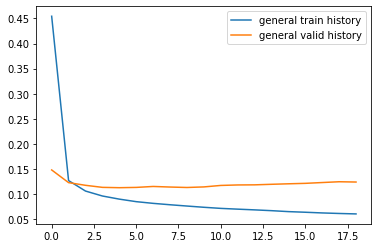

Epoch: 20
	Train Loss: 0.059 | Train PPL:   1.061
	 Val. Loss: 0.125 |  Val. PPL:   1.133


In [236]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

train_history = []
valid_history = []

N_EPOCHS = 20
CLIP = 100

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Применим нашу модель

In [237]:
def accuracy_model(model, iterator):
    model.eval()
    
    true_pred = 0
    num_pred = 0
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):

            output = model(batch.words)
            
            #output = [sent len, batch size, output dim]
            output = output.view(-1, output.shape[-1])
            tags = batch.tags.view(-1)
            
            #output = [sent len, batch size]
            predict_tags = np.argmax(output.cpu().numpy(), axis=1)
            true_tags = tags.cpu().numpy()

            #print(predict_tags)
            #print(true_tags)
            
            true_pred += np.sum((true_tags == predict_tags) & (true_tags != PAD_IDX))
            num_pred += np.prod(tags.shape)
        
    return round(true_pred / num_pred * 100, 3)

In [238]:
#humor dataset

#HID_SIZE 16, 20 epochs => 53.514
#HID_SIZE 32, 20 epochs => 60.638
#HID_SIZE 32, EMB_DIM = 64, 20 epochs => 61.734
#HID_SIZE 64, EMB_DIM = 100, 20 epochs => 62.347

#full dataset

#HID_SIZE 64, EMB_DIM = 100, 20 epochs =>

print("Accuracy:", accuracy_model(model, test_iterator), '%')

Accuracy: 94.481 %


Мы обучили нашу модель сначала на части датасета (категория humor), потом на полном датасете.

In [240]:
best_model = LSTMTagger(INPUT_DIM, EMB_DIM, HID_DIM, OUTPUT_DIM, DROPOUT, BIDIRECTIONAL).to(device)
best_model.load_state_dict(torch.load('best-val-model.pt'))

assert accuracy_model(best_model, test_iterator) >= 92

Пример решения нашей задачи

In [241]:
def print_tags(model, data):
    model.eval()
    
    with torch.no_grad():
        words, _ = data
        example = torch.LongTensor([WORD.vocab.stoi[elem] for elem in words]).unsqueeze(1).to(device)
        
        output = model(example).argmax(dim=-1).cpu().numpy()
        tags = [TAG.vocab.itos[int(elem)] for elem in output]

        for token, tag in zip(words, tags):
            print(f'{token:15s}{tag}')

In [242]:
print_tags(model, pos_data[-1])

From           NOUN
what           DET
I              VERB
was            VERB
able           ADJ
to             PRT
gauge          NOUN
in             ADP
a              DET
swift          ADJ
,              .
greedy         ADJ
glance         NOUN
,              .
the            DET
figure         NOUN
inside         ADP
the            DET
coral-colored  ADJ
boucle         NOUN
dress          NOUN
was            VERB
stupefying     VERB
.              .


## Сравните результаты моделей

Мы применили ряд моделей для задачи POS tagging.

Результаты:

1. Модель с использованием вероятностей (Марковские цепи). Точность 89.4%
2. Наивная модель (DefaultTagger). Точность 20%
3. Модель от Стенфорда. Точность 90.9%
4. Нейросетевая модель (BiLSTM). Точность 94.5%

